In [168]:
%reload_ext autoreload
%autoreload 2

import json
import os

import tqdm
import torch
import pyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from typing import Dict, Optional, NamedTuple

import mira
import mira.metamodel.io
import mira.modeling
import mira.sources.petri

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, PetriNetODESystem, Time, State, Solution, Observation, get_name
from pyciemss.utils import state_flux_constraint

pyro.settings.set(module_local_params=True)

In [169]:
class Scenario3Model(PetriNetODESystem):

    def __init__(self, G, *, noise_scale: float = 1):
        super().__init__(G)
        self.register_buffer("noise_scale", torch.as_tensor(noise_scale))
        for param in self.G.parameters.values():
            prior_loc = torch.log(torch.as_tensor(param.value if param.value is not None else 0.01))
            prior_scale = torch.as_tensor(0.1)
            setattr(self, get_name(param), pyro.nn.PyroSample(dist.LogNormal(prior_loc, prior_scale)))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        data = {} if data is None else data
        output = []
        for name, value in zip(self.var_order, solution):
            output.append(pyro.sample(
                name,
                pyro.distributions.Normal(value, self.noise_scale).to_event(1),
                obs=data.get(name, None),
            ))
        return tuple(output)


In [174]:
MODEL_PATH = "../../../program-milestones/6-month-milestone/evaluation/"

MODEL_FILES = {
    "biomd958": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958_mira.json"),
    ),
    "biomd960": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960_mira.json"),
    ),
    "sir": (
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir.json"),
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir_mira.json"),
    ),
}

DATA_ALIGNMENTS = {
    "biomd958": {
        "I": "Infectious",
        "H": "Hospitalised",
        "R": "Recovered",
        "D": "Fatalities",
    },
    "biomd960": {
        "I": "Infectious",
        "H": "Hospitalized",
        "R": "Recovered",
        "D": "Deceased",
    },
    "sir": {
        "I": "infected_population",
        # "R": "immune_population",
    },
}

DATA_SCALE = {
    "biomd958": 1e3,
    "biomd960": 1.,
    "sir": 1e7,
}

def load_data(filename, model_name):
    df = pd.read_csv(filename)
    alignment = DATA_ALIGNMENTS[model_name]

    dates = pd.to_datetime(df["date"])
    tspan = torch.as_tensor(np.array(
        (dates - dates.iloc[0]).dt.total_seconds() / (24 * 60 * 60)
    ))

    obs = {
        alignment[col]: torch.tensor(df[col].values) / DATA_SCALE[model_name]
        for col in df.columns if col in alignment
    }

    return tspan, obs

Initial state:  {'immune_population': tensor(3.), 'infected_population': tensor(2.), 'susceptible_population': tensor(1.)}


,Unnamed: 0,I,R,D,V,H,I_0-9,I_10-19,I_20-29,I_30-39,...,N_10-19,N_20-29,N_30-39,N_40-49,N_50-59,N_60-69,N_70-79,N_80-89,N_90-99,N_100+
count,629.00000,6.290000e+02,6.290000e+02,629.000000,6.290000e+02,629.000000,629.000000,6.290000e+02,6.290000e+02,6.290000e+02,...,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0,629.0
mean,314.00000,1.824148e+06,5.028726e+07,698484.737679,1.926294e+08,45946.521463,134016.499205,2.044128e+05,2.812316e+05,2.721816e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
std,181.72094,1.978525e+06,2.344204e+07,209485.974357,7.940621e+07,33017.880513,144782.838801,2.127507e+05,2.919734e+05,2.720895e+05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,1.793920e+05,1.329420e+07,253207.000000,3.081700e+04,0.000000,16245.000000,3.466000e+04,5.042200e+04,4.513700e+04,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
25%,157.00000,7.973120e+05,3.146800e+07,548324.000000,1.665916e+08,26372.000000,57118.000000,9.849300e+04,1.384470e+05,1.338750e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
50%,314.00000,1.397172e+06,4.320442e+07,684485.000000,2.199655e+08,37921.000000,97126.000000,1.429680e+05,2.006480e+05,1.978420e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
75%,471.00000,1.940458e+06,7.726970e+07,930841.000000,2.557774e+08,61421.000000,147339.000000,2.180180e+05,2.937820e+05,2.896690e+05,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0
max,628.00000,1.129407e+07,9.058354e+07,995401.000000,2.631494e+08,133263.000000,892161.000000,1.338296e+06,1.784822e+06,1.613565e+06,...,41765338.0,45180252.0,45598625.0,40561654.0,42008241.0,39723180.0,25830576.0,10732464.0,2704216.0,98160.0


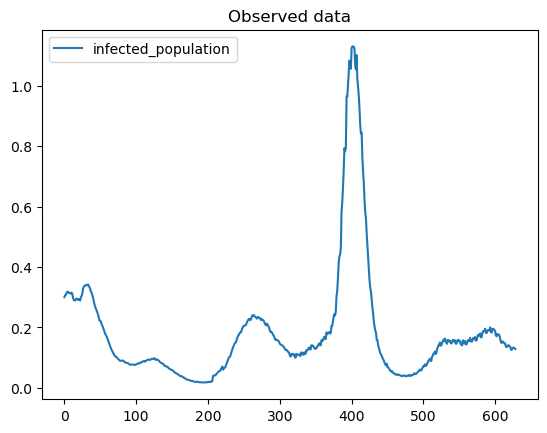

In [176]:
pyro.set_rng_seed(0)
pyro.clear_param_store()

DATA_FILE = "usa-IRDVHN_age.csv"
MODEL_NAME = "sir"
NUM_ITERATIONS = 200
OPTIM_PARAMS = {"lr": 1e-1}

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = torch.as_tensor(0.1)  #10. / DATA_SCALE[MODEL_NAME])

initial_state = model.default_initial_state
tspan, data = load_data(DATA_FILE, MODEL_NAME)
fake_data = {
    k: v for k, v in sample(model, 1, initial_state, tspan).items()
    if k in set(DATA_ALIGNMENTS[MODEL_NAME].values())
}

for name, col in data.items():
    plt.plot(tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [177]:
# posterior = infer_parameters(model, NUM_ITERATIONS, [], data, initial_state, tspan)
guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, hide=list(DATA_ALIGNMENTS[MODEL_NAME].values())))
loss_fn = pyro.infer.Trace_ELBO()(model, guide)

# initialize parameters
with torch.no_grad():
    loss_fn(initial_state, tspan, data)

optimizer = torch.optim.Adam(loss_fn.parameters(), **OPTIM_PARAMS)

for i in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    loss = loss_fn(initial_state, tspan, data)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"iteration {i}: loss = {loss.item()}")

iteration 0: loss = -11.261756896972656
iteration 10: loss = -68.19407653808594
iteration 20: loss = -128.27194213867188
iteration 30: loss = -146.34201049804688
iteration 40: loss = -152.6505889892578
iteration 50: loss = -154.0262451171875
iteration 60: loss = -154.5973663330078
iteration 70: loss = -154.86260986328125
iteration 80: loss = -154.93690490722656
iteration 90: loss = -154.97967529296875
iteration 100: loss = -154.988525390625
iteration 110: loss = -154.99383544921875
iteration 120: loss = -154.9949188232422
iteration 130: loss = -154.99569702148438
iteration 140: loss = -154.99591064453125
iteration 150: loss = -154.9957733154297
iteration 160: loss = -154.99609375
iteration 170: loss = -154.99581909179688
iteration 180: loss = -154.99600219726562
iteration 190: loss = -154.99598693847656


Text(0.5, 1.0, 'Posterior predictive distribution for model sir (approximation: MAP)')

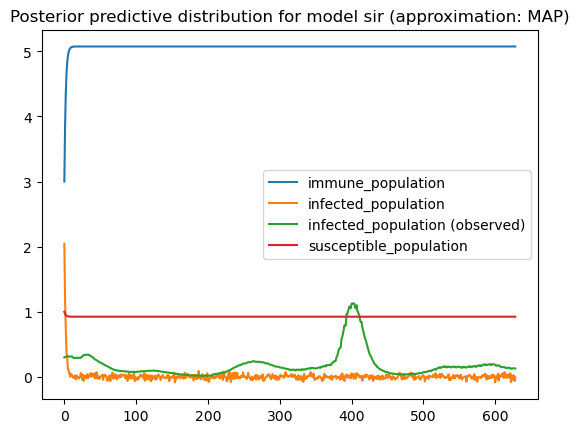

In [184]:
posterior_predictive = pyro.infer.Predictive(model, guide=guide, num_samples=10, return_sites=list(model.var_order.keys()))
result = posterior_predictive(initial_state, tspan)

for name in result.keys():
    plt.plot(tspan, result[name].mean(0).detach().numpy(), label=name)
    if name in data:
        plt.plot(tspan, data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approximation: MAP)")